# Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
import os
import sys
import random
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import cornac
from cornac.metrics import RMSE
from cornac.models import ItemKNN
from cornac.eval_methods import RatioSplit
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import zipfile
import kagglehub
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
%run ../src/plots.py

In [3]:
%run ../src/utils.py

In [4]:
set_seed()

## Load the Data from a CSV file

In [5]:
data = download_data()
data.head()

,title,channel_name,daily_rank,daily_movement,weekly_movement,snapshot_date,country,view_count,like_count,comment_count,description,thumbnail_url,video_id,channel_id,video_tags,kind,publish_date,langauge
0,Winky D - Propaganda (Official Video),winkyonline,1,0,0,2025-04-14,ZW,529245,43159,7712,Purchase the full Riddim Compilation from stor...,https://i.ytimg.com/vi/UScy08GG_ko/mqdefault.jpg,UScy08GG_ko,UC9iqkdRHEbX7hwEu9D6J8wg,NaN,youtube#video,2025-04-04 00:00:00+00:00,NaN
1,Donator Calvins - Door Ratovharwa (Mjolo Offic...,Zimcelebs Tv,2,0,48,2025-04-14,ZW,147848,5129,476,Copyright 2025 © Donator Calvins\nShot Leoy V\...,https://i.ytimg.com/vi/Wd3UQcILT78/mqdefault.jpg,Wd3UQcILT78,UCwx1kRB_tFZZk92EKeaZRdw,NaN,youtube#video,2025-04-08 00:00:00+00:00,NaN
2,SaintFloew - Fofa Fofa ft. Nutty O (Official M...,SaintFloew,3,0,2,2025-04-14,ZW,391827,11825,1052,SaintFloew teams up with Nutty O on a single t...,https://i.ytimg.com/vi/fsO1jS-X5go/mqdefault.jpg,fsO1jS-X5go,UCASJzkiQgCV4hsKAs6QY9Vg,"SaintFloew, santa, Zimbabwe, official, officia...",youtube#video,2025-04-03 00:00:00+00:00,sn
3,Zimbabwe protest I Protests against term exten...,SABC News,4,0,-2,2025-04-14,ZW,230064,0,259,For more on this we are joined by SABC News In...,https://i.ytimg.com/vi/kxi3r9Zr-JY/mqdefault.jpg,kxi3r9Zr-JY,UC8yH-uI81UUtEMDsowQyx1g,"SABC News, actuality, world news, local news",youtube#video,2025-03-31 00:00:00+00:00,en
4,Two Impending decisions in Zimbabwe - prophecy,Divine Kingdom TV - Diakoneo,5,2,45,2025-04-14,ZW,60506,1106,108,By Dr. Ian Ndlovu\n\nFor questions and inquiri...,https://i.ytimg.com/vi/mJhdiSIr_T4/mqdefault.jpg,mJhdiSIr_T4,UC6bJvJRulz2_-hujhBxMusw,"Prophecies, Prophecy, Prayer, sermon, Ian Ndlo...",youtube#video,2025-04-10 00:00:00+00:00,en-GB


## Filtering columns

As a starter to our project, we decided to cut some of the variables that are less likely to be userful in user recommendation. If needed, we will reload some of the columns needed.

In [6]:
data = filter_columns(data)
data.head()


,title,channel_name,country,view_count,like_count,comment_count,video_tags,kind,publish_date
0,Winky D - Propaganda (Official Video),winkyonline,ZW,529245,43159,7712,NaN,youtube#video,2025-04-04 00:00:00+00:00
1,Donator Calvins - Door Ratovharwa (Mjolo Offic...,Zimcelebs Tv,ZW,147848,5129,476,NaN,youtube#video,2025-04-08 00:00:00+00:00
2,SaintFloew - Fofa Fofa ft. Nutty O (Official M...,SaintFloew,ZW,391827,11825,1052,"SaintFloew, santa, Zimbabwe, official, officia...",youtube#video,2025-04-03 00:00:00+00:00
3,Zimbabwe protest I Protests against term exten...,SABC News,ZW,230064,0,259,"SABC News, actuality, world news, local news",youtube#video,2025-03-31 00:00:00+00:00
4,Two Impending decisions in Zimbabwe - prophecy,Divine Kingdom TV - Diakoneo,ZW,60506,1106,108,"Prophecies, Prophecy, Prayer, sermon, Ian Ndlo...",youtube#video,2025-04-10 00:00:00+00:00


In [7]:
explained_variance = pca(data)

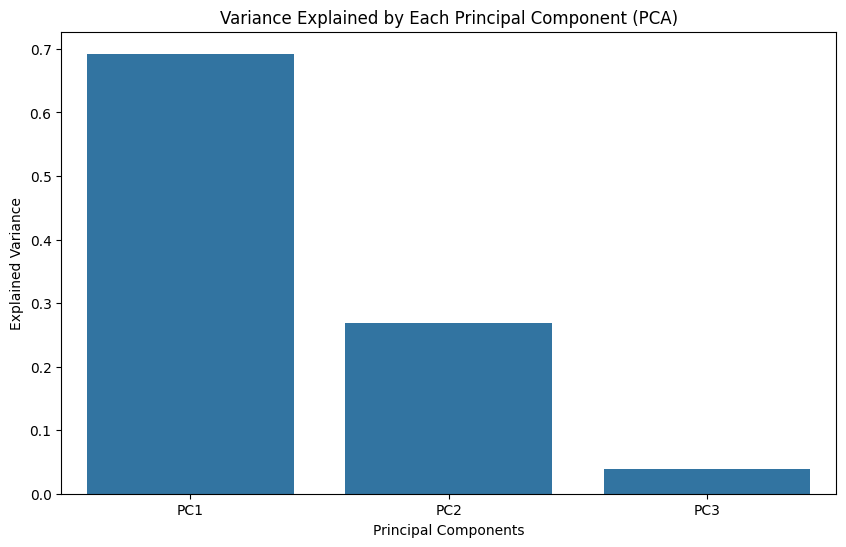

In [8]:
pca_barplot(explained_variance)

To analyze the relationship between the variables view_count, like_count, and comment_count, we applied Principal Component Analysis (PCA). The explained variance plot showed that the first principal component (PC1) captures approximately 70% of the total variance, indicating a strong correlation between the three variables.

This correlation suggests that these metrics represent the same underlying phenomenon: audience interaction with the content, i.e., engagement. Therefore, it makes sense to combine them into a single summary metric.

Although PCA allows the first component to be used directly as an engagement score, in this case we chose to construct our own engagement score, keeping all the original variables and manually combining them in a balanced way. This allows for greater control and interpretability of the final result.

In conclusion, PCA served as a supporting tool to confirm that view_count, like_count, and comment_count are correlated and, therefore, that it is valid to merge them into a single metric representative of engagement.

## Generating new dimensions

We decided to create a new column called "Engagement Score" that uses a function of weights to generate a number that explains user interaction with the video.

We used a simple formula as shown below: 

$$
\text{Engagement Score} = \frac{\text{like\_count} \times 2 + \text{comment\_count} \times 3}{\text{view\_count} + 1}
$$


We decided to use the weights assigned to each value taking into account the effort required for the user to interact with the videos, meaning that the harder the action is to do, the more importance it is given. The +1 on the view count is in order to avoid divisions by zero.

In [9]:
data_sorted = create_engagement(data)
# Display the first 5 rows
data_sorted.head(5)

,title,channel_name,country,view_count,like_count,comment_count,video_tags,kind,publish_date,engagement_score
1175850,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,PR,0,456719,11537,NaN,youtube#video,2024-09-08 00:00:00+00:00,948049.0
1181498,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,PR,0,455188,11468,NaN,youtube#video,2024-09-08 00:00:00+00:00,944780.0
1187145,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,PR,0,453200,11386,NaN,youtube#video,2024-09-08 00:00:00+00:00,940558.0
1192787,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,PR,0,450683,11282,NaN,youtube#video,2024-09-08 00:00:00+00:00,935212.0
1198430,THE WEEKND - SÃO PAULO LIVESTREAM,The Weeknd,PR,0,447515,11143,NaN,youtube#video,2024-09-08 00:00:00+00:00,928459.0


## Normalising the Score

In [10]:
data_sorted = normalized_data(data_sorted)

# Display the first 5 rows
data_sorted.head(5)

,title,engagement_score,scaled_engagement_score
1175850,THE WEEKND - SÃO PAULO LIVESTREAM,948049.0,10.000000
1181498,THE WEEKND - SÃO PAULO LIVESTREAM,944780.0,9.968967
1187145,THE WEEKND - SÃO PAULO LIVESTREAM,940558.0,9.928887
1192787,THE WEEKND - SÃO PAULO LIVESTREAM,935212.0,9.878136
1198430,THE WEEKND - SÃO PAULO LIVESTREAM,928459.0,9.814029


## Data Association

We will now dive deeper in our dataset, generating different datasets that provide different information on our data

In [11]:
channel_analysis = average_engagement_by_channel(data)
# Display the top 10 rows
channel_analysis.head(10)


,channel_name,avg_engagement_score,scaled_avg_engagement_score
27849,The Weeknd,267825.547331,10.000000
5794,Coachella,250434.010095,9.415575
11005,GoogleDoodles,165461.954545,6.560178
9098,FORMULA 1,27026.278074,1.908190
1754,Alok,23462.932742,1.788448
14497,Kenia Os,18924.956264,1.635954
9717,Flow Podcast,3586.588321,1.120524
13891,KAROL G,363.453403,1.012213
269,2SekundovyMato,90.802832,1.003051
20336,Nour Chiba نور شيبة,1.296628,1.000044


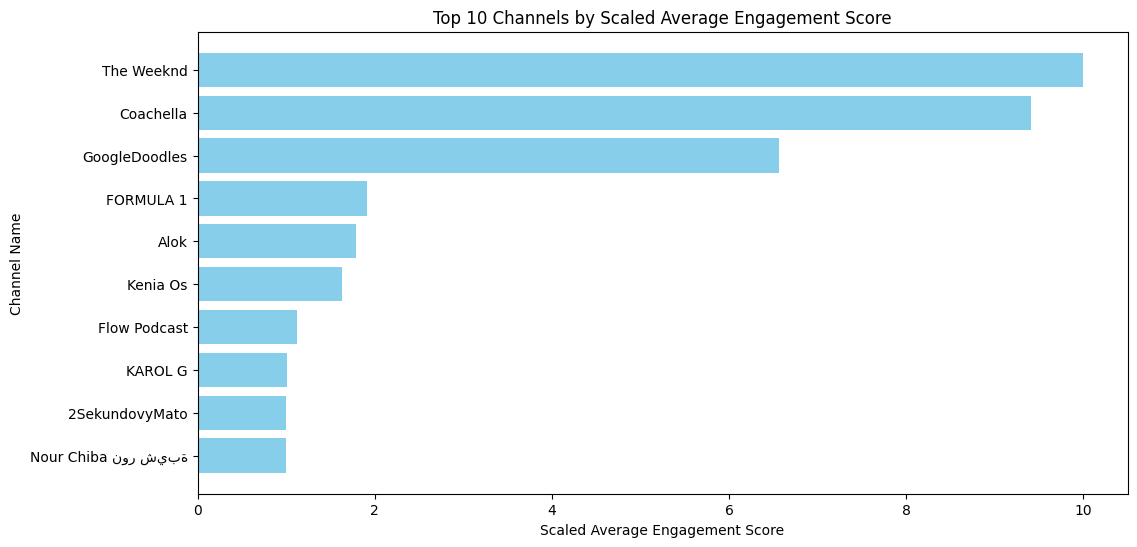

In [12]:
channel_analysis = channel_analysis.sort_values(by="scaled_avg_engagement_score", ascending=False)

top_10_channels(channel_analysis)

In [15]:
# Function to recommend similar channels
recommend_similar_channels(channel_analysis,"The Weeknd", top_n=5)


Channels similar to 'The Weeknd':
  - Coachella (Similarity: 1.000)
  - GoogleDoodles (Similarity: 1.000)
  - FORMULA 1 (Similarity: 1.000)
  - Alok (Similarity: 1.000)
  - Kenia Os (Similarity: 1.000)


['Coachella', 'GoogleDoodles', 'FORMULA 1', 'Alok', 'Kenia Os']

Now , we will analyze whether certain days/months have more viral videos.


/home/aritzrss/venv/big_data/youtube/src/utils.py:510: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  data["publish_month"] = data["publish_date"].dt.to_period("M")


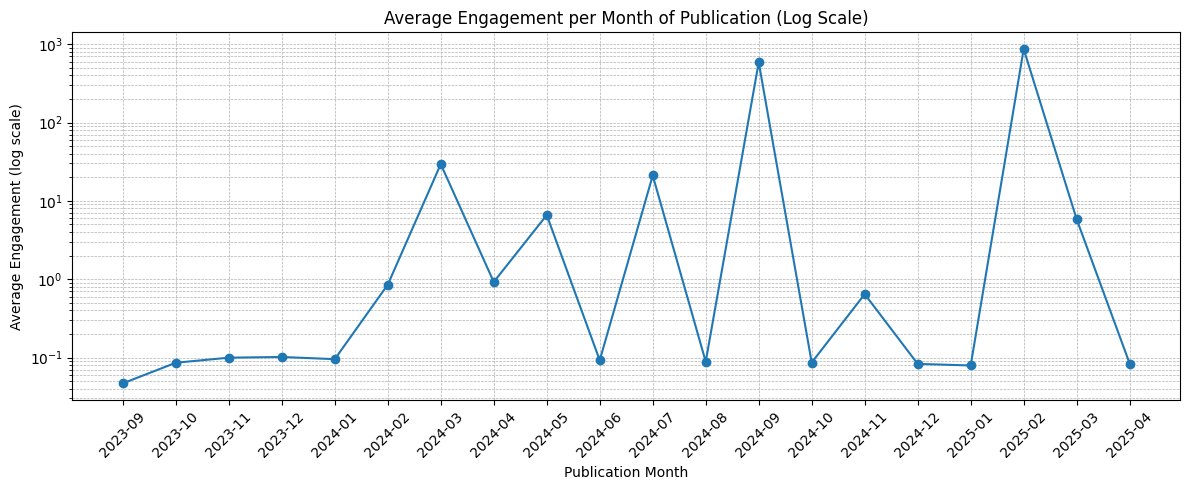

In [17]:
monthly_engagement_data = monthly_engagement(data)

plot_monthly_engagement(monthly_engagement_data)